# **Transfer Learning Aksara Jawa with VGG, Inception, and AlexNet**
---

## **Set up** 🔧
---

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Data Visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Model Hypertunning
# !pip install -q keras_tuner
# cls()
# import keras_tuner as kt

## Constants

Image size from dataset

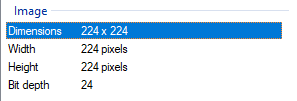

In [2]:
IMAGE_SIZE = 224
EPOCHS = 50
BATCH_SIZE = 32

# Hyperparameters
LEARNING_RATE = 1e-3 # learning rate for the optimizer

# Model training
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']

# Random Seed
random_seed = 32 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

## **Data Preparation** 📚
---

In [3]:
train_dir = '/kaggle/input/javanese-script-aksara-jawa-augmented/train/'
val_dir = '/kaggle/input/javanese-script-aksara-jawa-augmented/val/'
test_dir = '/kaggle/input/javanese-script-aksara-jawa-augmented/test/'

## **Data Loading** 🔃
---

In [4]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Show
print(f"Total number of classes: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                    train_dir,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='rgb',
                    batch_size=BATCH_SIZE,
                    image_size=(IMAGE_SIZE, IMAGE_SIZE),
                    shuffle=True,
                    seed=random_seed,
                    validation_split=None,
                    subset=None,
                    interpolation='bilinear',
                    follow_links=False
                )

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                    val_dir,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='rgb',
                    batch_size=BATCH_SIZE,
                    image_size=(IMAGE_SIZE, IMAGE_SIZE),
                    shuffle=True,
                    seed=random_seed,
                    validation_split=None,
                    subset=None,
                    interpolation='bilinear',
                    follow_links=False
                )

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                    test_dir,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='rgb',
                    batch_size=BATCH_SIZE,
                    image_size=(IMAGE_SIZE, IMAGE_SIZE),
                    shuffle=True,
                    seed=random_seed,
                    validation_split=None,
                    subset=None,
                    interpolation='bilinear',
                    follow_links=False
                )

Found 8400 files belonging to 20 classes.
Found 2400 files belonging to 20 classes.
Found 1200 files belonging to 20 classes.


In [6]:
# images, labels = next(iter(train_dataset))
# images

## **Data Distribution** 📊
---

In [7]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

del pie_chart
del bar_chart

## **Data Visualitation** 🖼
---

In [51]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 1, n_cols: int = 4, class_names=class_names, figsize=(10, 10), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 1.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (10, 10).
    """
    # Take one batch of data from the dataset
#     images, labels = next(iter(dataset.batch(n_rows * n_cols)))
    images, labels = next(iter(dataset))
    
    # Create a figure to display the images
    fig = plt.figure(figsize=figsize)
    
    # Loop over the number of rows and columns
    for i in range(n_rows * n_cols):
        
        label = int(labels[i].numpy())
        title = "true: "+class_names[label]
        
        if model:
            pred = model.predict(images[i][np.newaxis])
            
            if check:
                if label == np.argmax(pred):
                    continue
            
            pred_label = f"Pred: {np.argmax(pred)}"
            pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
            if class_names:
                pred_label += f" ({class_names[np.argmax(pred)]})"
            title += f"\n{pred_label} {pred_percentage}"
            
        # Create a subplot for each image
        ax = fig.add_subplot(n_rows, n_cols, i+1)    
        
        # Plot the image
        ax.imshow(images[i].numpy().astype("uint8"))
        
        # Set the title to the corresponding label
        ax.set_title(title)
        
        # Remove the axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Show the plot
    plt.show()

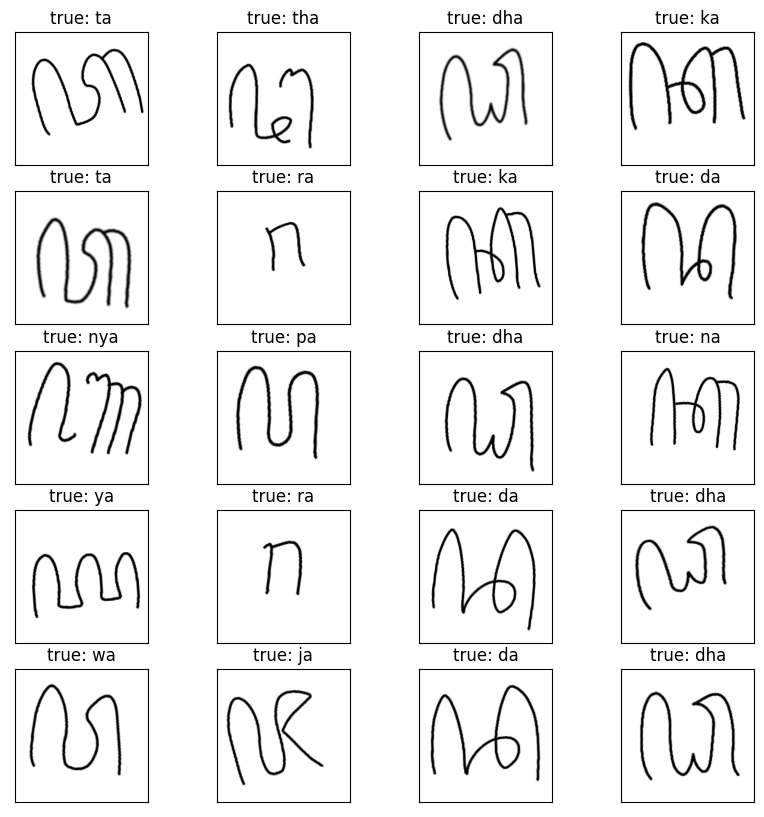

In [52]:
# Visualize Training Dataset
plot_images(train_dataset, n_rows=5)

## **VGG19 Zero-Shot** 0️⃣

In [10]:
# VGG19

vgg = VGG19(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

vgg.trainable = False

vgg_zero_shot = Sequential([
    vgg,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name='vgg19-aksara-jawa')

vgg_zero_shot.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

print("\nTraining VGG19 Model: ")
history = vgg_zero_shot.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint("vgg19_checkpoint.h5", save_best_only=True)
    ],
)

80134624/80134624 [==============================] - 0s 0us/step

Training VGG19 Model: 
Epoch 1/50
263/263 [==============================] - 67s 201ms/step - loss: 2.7657 - accuracy: 0.3812 - val_loss: 0.8290 - val_accuracy: 0.7629
Epoch 2/50
263/263 [==============================] - 63s 237ms/step - loss: 0.7146 - accuracy: 0.7664 - val_loss: 0.5282 - val_accuracy: 0.8371
Epoch 3/50
263/263 [==============================] - 56s 210ms/step - loss: 0.4025 - accuracy: 0.8838 - val_loss: 0.4214 - val_accuracy: 0.8783
Epoch 4/50
263/263 [==============================] - 56s 210ms/step - loss: 0.2910 - accuracy: 0.9250 - val_loss: 0.3995 - val_accuracy: 0.8917
Epoch 5/50
263/263 [==============================] - 56s 211ms/step - loss: 0.2341 - accuracy: 0.9449 - val_loss: 0.3435 - val_accuracy: 0.9021
Epoch 6/50
263/263 [==============================] - 56s 212ms/step - loss: 0.1849 - accuracy: 0.9568 - val_loss: 0.3541 - val_accuracy: 0.8954
Epoch 7/50
263/263 [=====================

In [11]:
test_loss, test_acc = vgg_zero_shot.evaluate(test_dataset)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

38/38 [==============================] - 7s 160ms/step - loss: 0.3212 - accuracy: 0.8992
Loss    : 0.3212
Accuracy: 89.92%


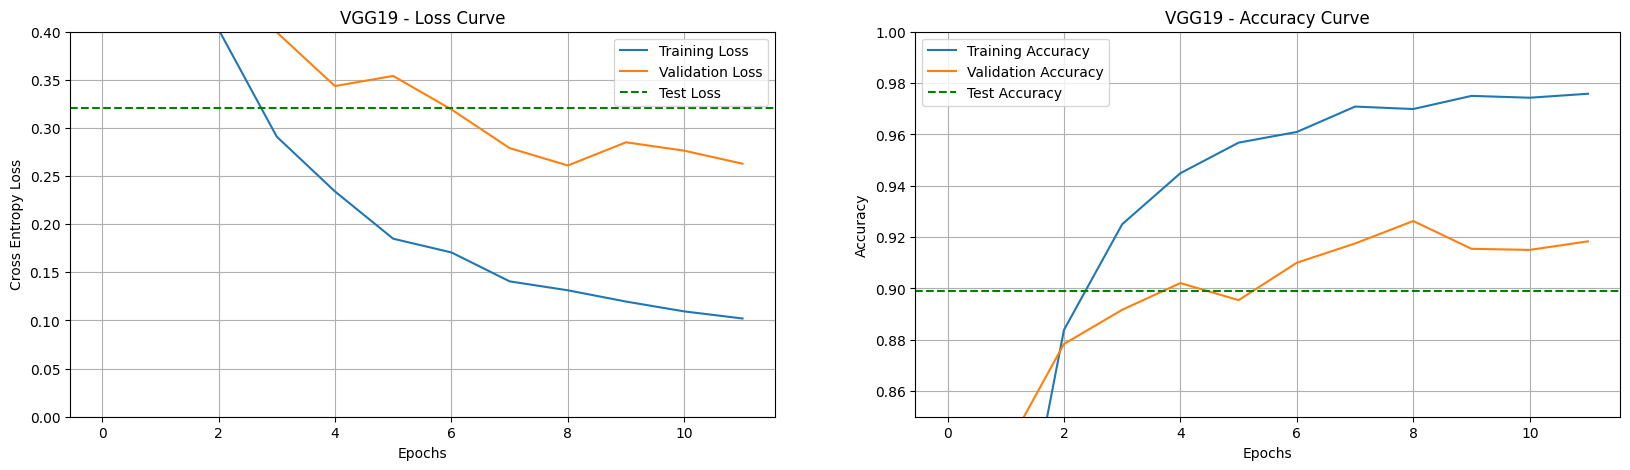

In [14]:
# Collect the history of the training run
history = pd.DataFrame(history.history)

# Create a figure to display the model's performance
plt.figure(figsize=(20, 5))

# Plot the loss curve in the first subplot
plt.subplot(1, 2, 1)
plt.title("VGG19 - Loss Curve")
plt.plot(history['loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")

# Horizontal line to show the testing performance
plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.ylim([0, 0.4])

# Show the legend and grid
plt.legend()
plt.grid()

# Plot the accuracy curve in the second subplot
plt.subplot(1, 2, 2)
plt.title("VGG19 - Accuracy Curve")
plt.plot(history['accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")

# Horizontal line to show the testing performance
plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.85, 1])

# Show the legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()

In [26]:
X_test = np.concatenate([x for x, y in test_dataset], axis=0)
y_test = np.concatenate([y for x, y in test_dataset], axis=0)

# Make predictions
baseline_pred = np.argmax(vgg_zero_shot.predict(X_test, verbose=0), axis=-1)
# best_pred = np.argmax(mobile_net_model.predict(X_test, verbose=0), axis=-1)

# Evaluate prediction : Precision
baseline_pre = precision_score(y_test, baseline_pred, average='macro')
# best_pre = precision_score(y_test, best_pred, average='macro')

# Evaluate prediction : Recall
baseline_recall = recall_score(y_test, baseline_pred, average='macro')
# best_recall = recall_score(y_test, best_pred, average='macro')

# Evaluate prediction : F1 Score
baseline_f1 = f1_score(y_test, baseline_pred, average='macro')
# best_f1 = f1_score(y_test, best_pred, average='macro')

print("{:20}".format("Baseline Performance"))
print("{:10} : {:.5}".format("Precision", baseline_pre))
print("{:10} : {:.5}".format("Recall", baseline_recall))
print("{:10} : {:.5}".format("F1 Score", baseline_f1))

Baseline Performance
Precision  : 0.043914
Recall     : 0.045
F1 Score   : 0.04403


In [38]:
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.06      0.08      0.07        60
           1       0.12      0.12      0.12        60
           2       0.04      0.03      0.04        60
           3       0.05      0.05      0.05        60
           4       0.02      0.02      0.02        60
           5       0.02      0.03      0.02        60
           6       0.03      0.03      0.03        60
           7       0.04      0.05      0.05        60
           8       0.02      0.02      0.02        60
           9       0.07      0.07      0.07        60
          10       0.04      0.03      0.04        60
          11       0.05      0.05      0.05        60
          12       0.00      0.00      0.00        60
          13       0.03      0.03      0.03        60
          14       0.07      0.07      0.07        60
          15       0.06      0.07      0.06        60
          16       0.03      0.02      0.02        60
          17       0.07    

## **VGG19 Predictions** 🔍

1/1 [==============================] - 0s 21ms/step


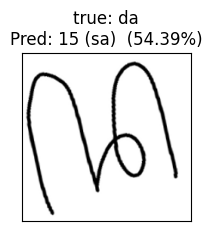

In [56]:
plot_images(test_dataset, model=vgg_zero_shot, n_rows=3, check=True)

In [36]:
vgg_zero_shot.save('aksara_vgg19.h5')